This assignment is to practice Convolutional Neural Networks and Transfer Learning with Keras. The objective is to build a classification model based on a pre-trained ImageNet CNN to classify cats and dog images. 

**What you need to do?**
1. Download the “cats and dogs”dataset from this link: https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
2. You can use “tf.keras.preprocessing.image_dataset_from_directory”to create a dataset.Don’t forget to do required preprocessing and data augmentation.
3. Built a classification model based on a pre-trained ResNet101 (you need to change the last layer for two classes)and fine-tune it.
4. Plot the learning and accuracy curves. Report the best validation accuracy.
5. Repeat the above process using pre-trained MobileNetV2and report the validation accuracy.
6. Compare the speed(both training and prediction) and accuracy of the two models.

Good luck!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#Data Download
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


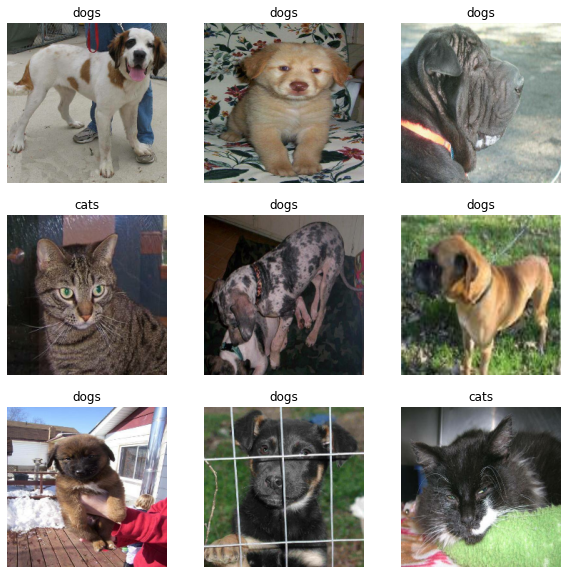

In [ ]:
#Show the first nine images and labels from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Create test dataset as origional file did not inlclude one.
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
# using the preprocessing method included with the model.
preprocess_input  = tf.keras.applications.resnet50.preprocess_input

In [ ]:
# # Create the base model from the pre-trained model ResNet101.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet.ResNet101(
    include_top=False, 
    weights='imagenet', 
    #input_tensor=None,
    input_shape=IMG_SHAPE, 
    #pooling=None, 
    #classes=1000
)

171450368/171446536 [==============================] - 2s 0us/step


In [ ]:
# feature extractor converts each 224x224x3 image into a 7x7x2048 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [ ]:
# Convolutional base created from the previous step and to use as a feature extractor
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
# Add a classification head to generate predictions from the block of features.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 134ms/step - loss: 0.8068 - accuracy: 0.5012


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.50


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 19s 196ms/step - loss: 0.6228 - accuracy: 0.6240 - val_loss: 0.4001 - val_accuracy: 0.8168
Epoch 2/10
63/63 [==============================] - 13s 194ms/step - loss: 0.3466 - accuracy: 0.8505 - val_loss: 0.2448 - val_accuracy: 0.9332
Epoch 3/10
63/63 [==============================] - 12s 194ms/step - loss: 0.2433 - accuracy: 0.9120 - val_loss: 0.1764 - val_accuracy: 0.9641
Epoch 4/10
63/63 [==============================] - 13s 196ms/step - loss: 0.1882 - accuracy: 0.9375 - val_loss: 0.1291 - val_accuracy: 0.9777
Epoch 5/10
63/63 [==============================] - 13s 195ms/step - loss: 0.1483 - accuracy: 0.9575 - val_loss: 0.1084 - val_accuracy: 0.9814
Epoch 6/10
63/63 [==============================] - 12s 194ms/step - loss: 0.1221 - accuracy: 0.9695 - val_loss: 0.0942 - val_accuracy: 0.9814
Epoch 7/10
63/63 [==============================] - 12s 193ms/step - loss: 0.1071 - accuracy: 0.9765 - val_loss: 0.0842 - val_accuracy: 0.9851

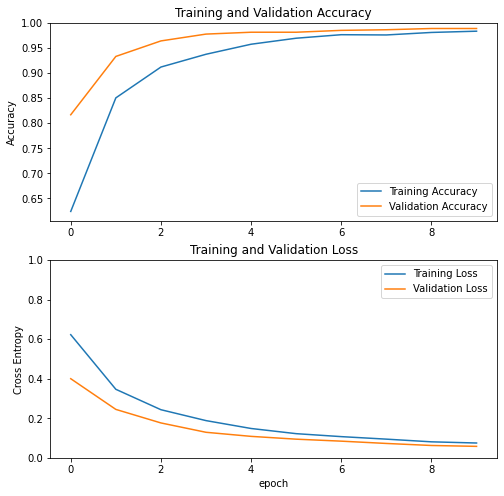

In [ ]:
# Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0]
Labels:
 [0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0]


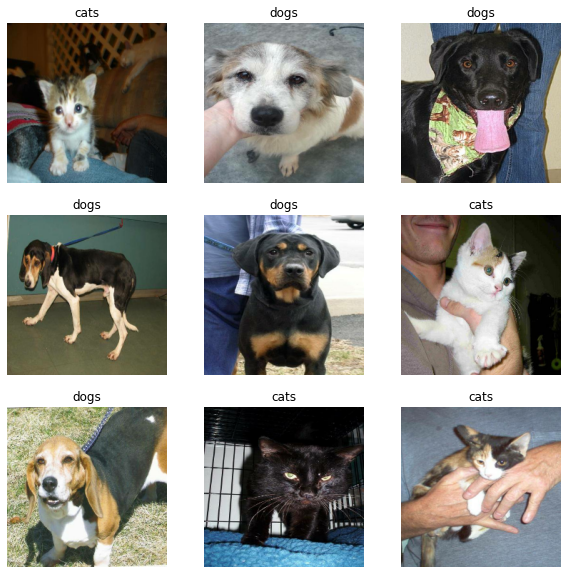

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
keras.backend.clear_session()

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 3s 49ms/step - loss: 0.8621 - accuracy: 0.4616
initial loss: 0.86
initial accuracy: 0.46


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 79ms/step - loss: 0.7038 - accuracy: 0.5660 - val_loss: 0.5680 - val_accuracy: 0.6460
Epoch 2/10
63/63 [==============================] - 5s 77ms/step - loss: 0.4854 - accuracy: 0.7260 - val_loss: 0.4050 - val_accuracy: 0.7785
Epoch 3/10
63/63 [==============================] - 5s 79ms/step - loss: 0.3513 - accuracy: 0.8325 - val_loss: 0.2945 - val_accuracy: 0.8700
Epoch 4/10
63/63 [==============================] - 5s 80ms/step - loss: 0.2778 - accuracy: 0.8830 - val_loss: 0.2357 - val_accuracy: 0.9109
Epoch 5/10
63/63 [==============================] - 5s 78ms/step - loss: 0.2289 - accuracy: 0.9070 - val_loss: 0.2034 - val_accuracy: 0.9344
Epoch 6/10
63/63 [==============================] - 5s 78ms/step - loss: 0.1907 - accuracy: 0.9365 - val_loss: 0.1729 - val_accuracy: 0.9517
Epoch 7/10
63/63 [==============================] - 5s 81ms/step - loss: 0.1735 - accuracy: 0.9340 - val_loss: 0.1535 - val_accuracy: 0.9517
Epoch 8/10
63

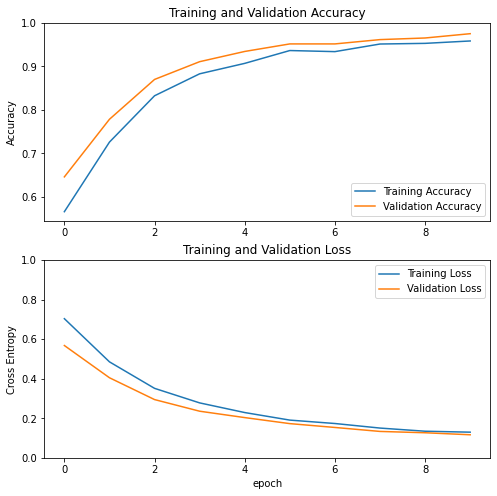

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1]
Labels:
 [0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1]


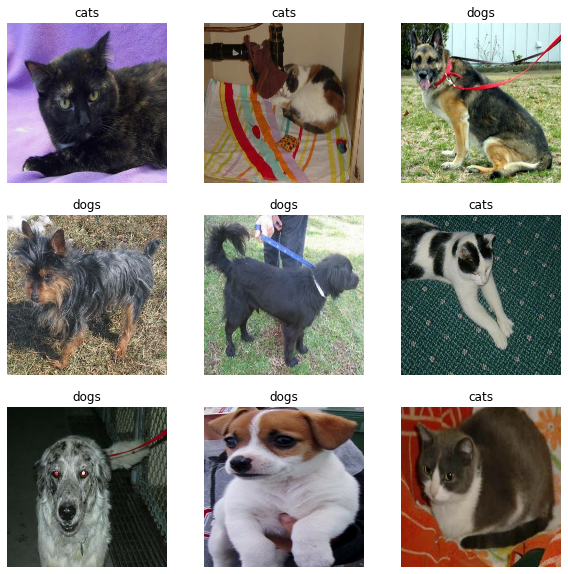

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")